# The Late Show with Stephen Colbert Analysis

## Standard Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns
from textblob import TextBlob
import statsmodels.formula.api as smf

plt.rcParams['figure.figsize'] = (20,6)

from bokeh.plotting import output_notebook, show
output_notebook(hide_banner=True)

from IPython.display import display, HTML
def printb(*args):
    s = " ".join([str(x) for x in args])
    display(HTML('<strong>%s</strong>' % s))

from analysis_utils import create_df, plot_interactive_timeseries

## Load Data

In [2]:
episodes = create_df()
episodes.head()

,number,rating,rating_count,airdate,title,description,text
0,1,7.5,97.0,2015-09-08,George Clooney/Governor Jeb Bush/Mavis Staples...,"Stephen Colbert succeeds David Letterman as ""L...","OH, SAY CAN YOU SEE BY THE DAWN'S EARLY LIGHT ..."
1,2,7.5,58.0,2015-09-09,Scarlett Johansson/Elon Musk/Kendrick Lamar,Scarlett Johansson (Avengers: Age of Ultron (2...,♪ ♪ ♪ Captioning sponsored by CBS\nStephen: W...
2,3,8.6,66.0,2015-09-10,Vice President Joe Biden/Travis Kalanick/Toby ...,Vice President Joe Biden; Uber CEO Travis Kala...,(CHEERS AND APPLAUSE)\nStephen: HEY! (CHEERS A...
3,4,7.4,42.0,2015-09-11,Amy Schumer/Stephen King/Troubled Waters,Amy Schumer (Trainwreck (2015)); author Stephe...,COME ON! COME ON! ♪ ♪ ♪ ( CHEERS AND APPLAUSE ...
4,5,7.9,36.0,2015-09-14,Emily Blunt/Justice Stephen Breyer/The Dead We...,Actress Emily Blunt (Sicario (2015)); Supreme ...,"( BAND PLAYING ""LATE SHOW"" THEME ) ( CHEER..."


## Distribution of Rating and Rating Count

Number of episodes with null rating (< 5 ratings)

In [3]:
episodes.rating.isnull().sum()

17

In [4]:
episodes[['rating', 'rating_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,125.0,7.572,0.567905,5.9,7.2,7.7,8.0,9.0
rating_count,125.0,13.352,12.346644,5.0,7.0,9.0,14.0,97.0


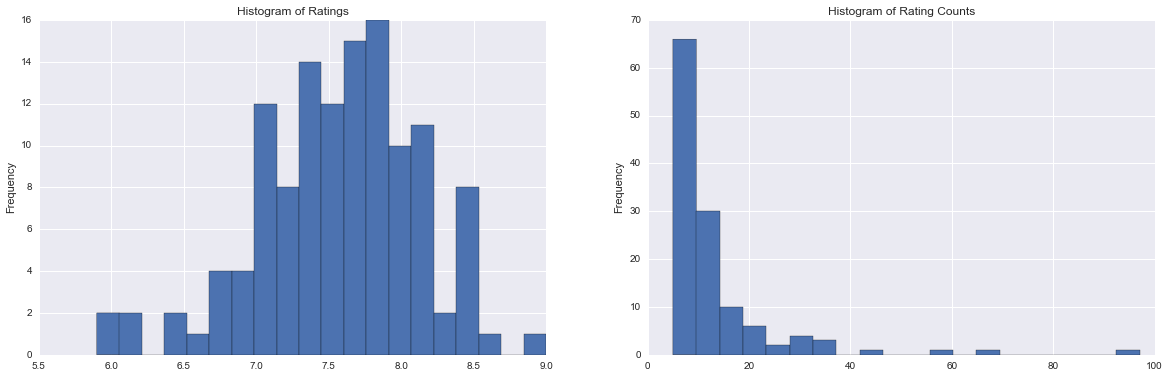

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

episodes.rating.plot(kind='hist', bins=20, ax=ax1, title="Histogram of Ratings")
episodes.rating_count.plot(kind='hist', bins=20, ax=ax2, title="Histogram of Rating Counts")

## Ratings over Time

In [6]:
p = plot_interactive_timeseries(x='airdate', y='rating', data=episodes, 
                                title="Ratings per Episode on The Late Show with Stephen Colbert")
show(p)

## Ratings Count over Time

In [7]:
p = plot_interactive_timeseries(x='airdate', y='rating_count', data=episodes, 
                                title="Number of Ratings per Episode on The Late Show with Stephen Colbert")
show(p)

## Sentiment Analysis

In [8]:
rows = []
for index, row in episodes.iterrows():
    if pd.isnull(row.text): continue
    blob = TextBlob(row.text)
    sentiment = blob.sentiment
    row = {"number": row.number, "polarity": sentiment.polarity, "subjectivity": sentiment.subjectivity}
    rows.append(row)

sentiment = pd.DataFrame(rows).set_index('number')
episodes = pd.concat([episodes.set_index('number'), sentiment], axis=1).reset_index()
episodes[['number', 'airdate', 'polarity', 'subjectivity', 'rating', 'rating_count']].head()

,number,airdate,polarity,subjectivity,rating,rating_count
0,1,2015-09-08,0.177883,0.527630,7.5,97.0
1,2,2015-09-09,0.177891,0.529692,7.5,58.0
2,3,2015-09-10,0.210318,0.500193,8.6,66.0
3,4,2015-09-11,0.148042,0.523307,7.4,42.0
4,5,2015-09-14,0.171476,0.469937,7.9,36.0


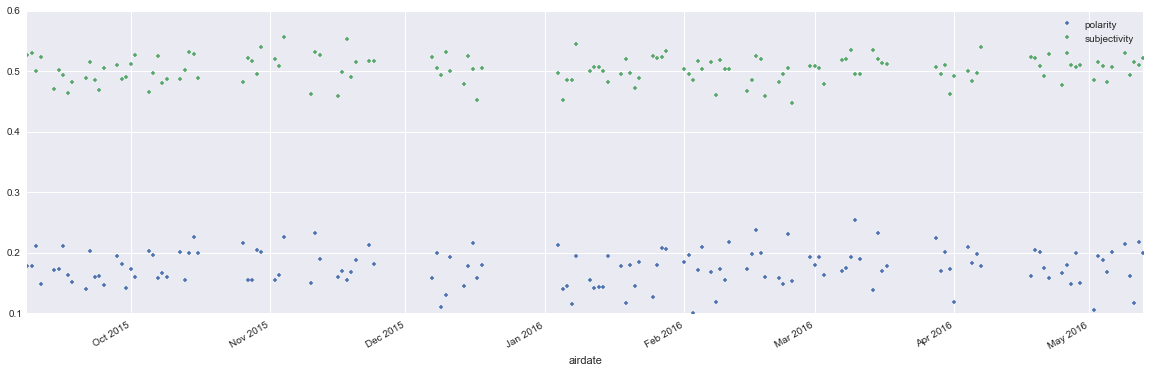

In [9]:
episodes.set_index('airdate').polarity.plot(style='.')
episodes.set_index('airdate').subjectivity.plot(style='.')
plt.legend()

In [10]:
mod = smf.ols(formula='rating ~ subjectivity + polarity', data=episodes)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.2923
Date:                Mon, 16 May 2016   Prob (F-statistic):              0.747
Time:                        00:55:02   Log-Likelihood:                -102.81
No. Observations:                 120   AIC:                             211.6
Df Residuals:                     117   BIC:                             220.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        6.7362      1.191      5.658      0.000         4.378     9.094
subjectivity     1.4863      2.426      0.613      0.541        -3.319     6.291
polarity         0.5739      1.867      0.307      0.759        -3.124     4.271
==============================================================================
Omnibus:                        5.931   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.419
Skew:                          -0.494   Prob(JB):                       0.0666
Kurtosis:                       3.330   Cond. No.                         58.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Subtitles of Most Recent Episodes

In [11]:
for i, row in episodes.tail(5).iterrows():
    if pd.isnull(row.text): continue
    printb(row.number, row.title)
    print(row.text[:800] + '...')
    print("\n----------------------------------\n")

OH, COME ON. ALL RIGHT, COME ON. OH, JEEZ. OH. MY HAND IS STUCK.
IT'S A LOST CAUSE.
IT IS NOT A LOST CAUSE. (CHEERS AND APPLAUSE).
Stephen: WHAT ARE YOU DOING HERE?
WELL, I DON'T TAKE MONEY FROM BILLIONAIRES BUT I DO CHECK EVERY VENDING MACHINE CHANGE SLOT.
Stephen: COME ON. $27.
NOTHING.
Stephen: HEY, WAIT, AREN'T YOU GOING TO.
TELL YOU ABOUT THE WEST VIRGINIA PRIMARY TOMORROW?
Stephen: AH, SURE?
WELL, I THINK WE GOT A SHOT TO WIN. AND I'LL TELL YOU WHY. IT'S BECAUSE IN WEST VIRGINIA LIKE EVERY PLACE ELSE IN THIS COUNTRY TOO MANY PEOPLE ARE WORKING LONGER HOURS FOR LOW WAGES AND THEY WANT CHANGE, STEPHEN.
Stephen: OKAY, BUT EVEN IF YOU DO WELL TOMORROW, THE DELEGATE MATH IS AGAINST YOU. SO ISN'T THIS WIN REALLY ONLY A WIN. IT'S NOT REALLY A WIN.
NOT REALLY.
Stephen: MAYBE BOTH. I DON'T KN...

----------------------------------



Stephen: KATIE COURIC.
HEY, STEPHEN.
Stephen: SO LOVELY TO SEE YOU. THANKS FOR BEING ON THE SHOW.
ARE YOU KIDDING? SO HAPPY TO BE HERE.
Stephen: MARNG YOU ARE GOING TO LOOK FANTASTIC IN THE CHICKEN SUIT.
WHAT DO YOU MEAN.
Stephen: I FORGOT TO TELL YOU WE ARE DOING THIS THING WHERE WE INTERVIEW OUR GUESTS IN COSTUMES.
STEPHEN, I'M A SERIOUS JOURNALIST. I AM NOT GOING TO WEAR A CHICKEN SUIT.
Stephen: IS IT OKAY IF I WEAR THE CHICKEN SUIT?
IT'S JUR SHOW, KNOCK YOURSELF OUT.
Stephen: YOU CAN BE THE HORSE.
GREAT!
TONIGHT, STEPHEN WELCOMES CHLOE GRACE MORETZ KATIE COURIC CHARLAMAGNE THA GOD FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW WITH STEPHEN COLBERT"!  Captioning sponsored by CBS ( CHEERS AND APPLAUSE )
Stephen: HEY! HEY! THANK YOU, JON! GOOD TO SEE YOU, MY MA...

----------------------------------



Captioning sponsored by CBS
Stephen: BUT I LOVE DONUTS. JUST TELL THEM TO BRING THE DONUTS. WE DON'T HAVE TO TALK ABOUT THE MOVIE. I'D LOVE TO HAVE HIM ON THE SHOW. THAT WOULD BE GREAT. LIZ.
STEPHEN.
Stephen: WE MEET AGAIN. WHAT CAN I DO FOR YOU?
IN THE BROADWAY COLD OPEN, DO YOU ACTUALLY WANT TO PARTICIPATE IN THE DANCE, OR DO YOU JUST WANT TO BANG ON A DRUM AND NOT DO MUCH GLP I'LL JUST BANG ON A DRUM.
GREAT.
Stephen: ANY OTHER FOLLOW-UP QUESTIONS.
YES, DOES THAT MEAN THEY DON'T HAVE TO COME EARLY AND REHEARSE.
Stephen: YES, I'M BEAMING UP. I WANT TO DANCE, OR I DON'T. FIND OUT.
TONIGHT, STEPHEN WELCOMES KATE BECKINSALE AND A MUSICAL PERFORMANCE BY DESIIGNER. FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW" WITH STEPHEN COLBERT"! ( CHEERS AND APPLAUSE )
Stephen...

----------------------------------



Stephen: I AM SO EXCITED ABOUT TONIGHT'S SHOW. BOTH RYAN GOSLING AND RUSSELL CROWE ARE HERE AND I'M GOING TO STOP BY AND SAY HI. DO ALL OF YOU NEED TO BE HERE RIGHT NOW? (LAUGHTER)
YES, WE ALL NEED TO BE DOWN HERE. FOR WORK.
Stephen: OH, REALLY? SO YOU'RE NOT JUST STANDING HERE WAITING FOR RYAN GOSLING AND RUSSELL CROWE TO WALK OUT?
NO. ARE THEY ON THE SHOW TONIGHT? WE DIDN'T EVEN REALIZE. AWKWARD.
Stephen: WELL, I'M GOING TO SAY HI.
WE WILL WATCH YOU.
Announcer: TONIGHT, STEPHEN WELCOMES RYAN GOSLING AND RUSSELL CROWE! JESSIE MUELLER! AND A MUSICAL PERFORMANCE BY ANIMAL COLLECTIVE! FEATURING JON BATISTE AND "STAY HUMAN"! (CHEERS AND APPLAUSE) AND NOW IT'S TIME FOR "THE LATE SHOW" WITH STEPHEN COLBERT! (CHEERS AND APPLAUSE) ♪  Captioning sponsored by CBS ♪ ♪ ♪
Stephen: HEY! HEY, EVERYBODY!...

----------------------------------



ARE YOU READY FOR MAIRK UP?
Stephen: YEAH. I WANT TO TRY A DIFFERENT LOOK TONIGHT, THOUGH.
OKAY. ( LAUGHTER ).
Stephen: THAT'S A LITTLE TOO SALVADOR DAWLEY. SOMETHING ELSE. OOH, I LIKE McGREET, BUT I WON'T BE ABLE TO SEE MY GUESTS. SOMETHING ELSE. WOW! PICASSO IS BOLD, BUT MY GLASSES WON'T FIT. ( LAUGHTER ) JUST GIVE ME SOMETHING SIMPLE AND MASCULINE. OH, YEAH, SEXY GINGER.
TONIGHT, STEPHEN WELCOMES MATT BOMER ZACH WOODS AND A PERFORMANCE BY COMEDIAN NICK GRIFFIN. FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW WITH STEPHEN COLBERT"! ( CHEERS AND APPLAUSE )
Stephen: HEY! HEY! BOOM! BA! WELCOME. HEY, EVERYBODY. HEY, YOU DOWN THERE. SORRY, I DROPPED MY PHONE. I DROPPED MY PHONE. I ALWAYS JUST CARRY A PHONE WITH ME. JUST IN CASE. I GOTTA GO. I GOTTA TALK TO-- SORRY,...

----------------------------------

